In [2]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from tabulate import tabulate

warnings.filterwarnings('ignore')
mpl.style.use("fivethirtyeight")

## Helper functions

In [8]:
def reset_seed(func):
    def wrapper(*args, **kwargs):
        np.random.seed(0)
        return func(*args, **kwargs)
    return wrapper

def make_cdf_confidence_band(samples, confidence):
    """Construct a confidence band for a CDF given samples drawn from that CDF.

    Parameters
    ----------
    samples
        Samples drawn from a CDF
    confidence
        Confidence level (e.g., 0.95)

    Returns
    -------
    x, F_hat, L, U
        (x, F_hat) are the x and y coordinates of the empirical CDF
        (x, L) are the x and y coordinates of the lower bound and
        (x, U) are the x and y coordinates of the upper bound
    """
    n = samples.shape[0]
    α = 1. - confidence
    ε_n = np.sqrt(1. / (2 * n) * np.log(2. / α))
    x = np.sort(samples)
    F_hat = np.arange(1, x.size + 1) / x.size
    L = np.maximum(F_hat - ε_n, 0.)
    U = np.minimum(F_hat + ε_n, 1.)
    return x, F_hat, L, U

In [3]:
import requests
from io import StringIO

def fetch_data(name, index_col=None, skiprows= 0):
    """Downloads and returns data as a Pandas DataFrame."""
    url = f"https://www.stat.cmu.edu/~larry/all-of-statistics/=data/{name}.dat"
    response = requests.get(url, verify=False)
    if response.status_code != 200:
        raise RuntimeError
    return pd.read_csv(StringIO(response.text), sep='\s+', index_col=index_col, skiprows=skiprows)

## 1.

Note that

$$
\mathbb{E}\hat{F}_{n}(x)=\mathbb{E}I(X_{1}\leq x)=\mathbb{P}(X_{1}\leq x)=F(x).
$$

Moreover,

$$
\mathbb{V}\hat{F}_{n}(x)=\frac{1}{n}\mathbb{V}I(X_{1}\leq x)=\frac{1}{n}F(x)\left(1-F(x)\right).
$$

By the bias-variance decomposition, the MSE is equal to the variance
and converges to zero. Equivalently, we can say that $\hat{F}_{n}(x)$
converges to $F(x)$ in quadratic mean. This implies convergence in
probability (alternatively, we could have used the WLLN).

## 2.

*Assumption*.
The Bernoulli random variables in the statement of the question are independent.

Since $p=\mathbb{E}X_{1}$, the plug-in estimator is $\hat{p}=\overline{X}$.
Moreover, $\operatorname{se}\hat{p}=(\mathbb{V}X_{1})/n=p(1-p)/n$.
Since $\hat{p}$ is a sample mean, the CLT implies (see Appendix) that an approximate $1 - \alpha$ confidence interval for $p$ is 

$$
\hat{p}\pm z_{\alpha / 2} \times \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}.
$$

Similarly, an approximate $1-\alpha$ confidence interval for $\hat{p}-\hat{q}$ is 

$$
\hat{p}-\hat{q}\pm z_{\alpha / 2} \times \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}+\frac{\hat{q}\left(1-\hat{q}\right)}{n}}.
$$

In the case of a 90% confidece interval (i.e., $\alpha = 0.1$), the z-score is approximately 1.64485.

In [9]:
@reset_seed
def f(confidence=0.9, n=1_000, p=0.3):
    X = np.random.rand(10_000, n) < p
    p_hat = X.mean(axis=1)
    α = 1. - confidence
    z = scipy.stats.norm.ppf(1 - α / 2)
    eps = z * np.sqrt(p_hat * (1. - p_hat) / n)
    return ((p_hat - eps <= p) & (p <= p_hat + eps)).mean()

f()

0.9059

In [10]:
@reset_seed
def f(confidence=0.9, m=900, n=1_000, p=0.3, q=0.7):
    X = np.random.rand(10_000, n) < p
    Y = np.random.rand(10_000, m) < q
    p_hat = X.mean(axis=1)
    q_hat = Y.mean(axis=1)
    α = 1. - confidence
    z = scipy.stats.norm.ppf(1 - α / 2)
    eps = z * np.sqrt(p_hat * (1. - p_hat) / n + q_hat * (1. - q_hat) / m)
    return ((p_hat - q_hat - eps <= p - q) & (p - q <= p_hat - q_hat + eps)).mean()

f()

0.9003

## 3.

In [11]:
@reset_seed
def plot_confidence_band(cdf_func, sample_func, confidence=0.95, n=100):
    x, _, L, U = make_cdf_confidence_band(sample_func(n), confidence=confidence)
    xx = np.linspace(x.min(), x.max(), 1001)
    plt.step(xx, cdf_func(xx))
    plt.fill_between(x, y1=L, y2=U, alpha=0.3, step="post")
    plt.title(f"{confidence * 100}% confidence band from {n} samples")

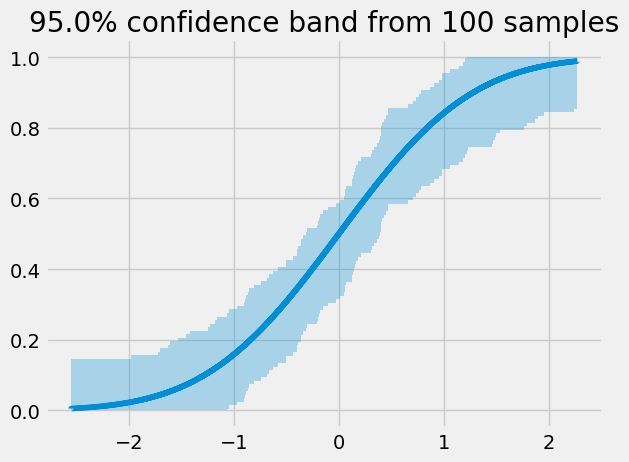

In [12]:
plot_confidence_band(scipy.stats.norm.cdf, np.random.randn)

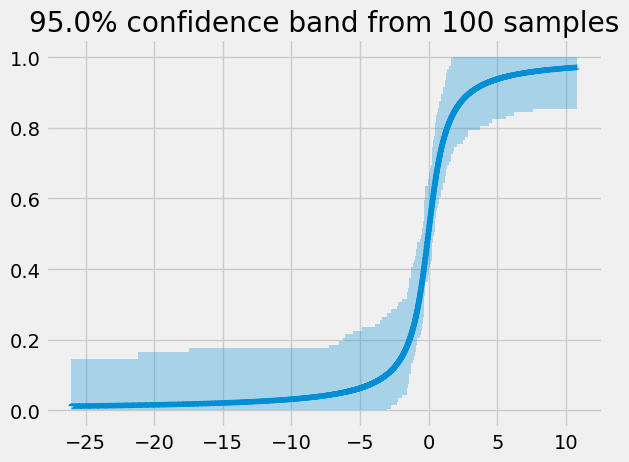

In [13]:
plot_confidence_band(scipy.stats.cauchy.cdf, np.random.standard_cauchy)

In [14]:
@reset_seed
def count_number_of_cdf_capturing_confidence_bands(cdf_func, sample_func, confidence=0.95, m=1_000, n=100):
    count = 0
    for _ in range(m):
        x, _, L, U = make_cdf_confidence_band(sample_func(n), confidence=confidence)
        F = cdf_func(x)
        count += np.all((L <= F) & (F <= U))
    return count

In [54]:
print(f"{count_number_of_cdf_capturing_confidence_bands(scipy.stats.norm.cdf, np.random.randn)} of 1000 normal CDFs were captured by the 95% confidence band")

960 of 1000 normal CDFs were captured by the 95% confidence band


In [55]:
print(f"{count_number_of_cdf_capturing_confidence_bands(scipy.stats.cauchy.cdf, np.random.standard_cauchy)} of 1000 Cauchy CDFs were captured by the 95% confidence band")

978 of 1000 Cauchy CDFs were captured by the 95% confidence band


## 4.

By our findings in Question 1 and the CLT,

$$
\sqrt{n}\left(\hat{F}(x)-F(x)\right)\rightsquigarrow N(0,F(x)\left(1-F(x)\right)).
$$

*Remark*. The closer (respectively, further) $F(x)$ is to $1/2$, the more (respectively, less) uncertainty there is in the empirical distribution evaluated at $x$.

## 5.

Without loss of generality, assume $x<y$. Then,

$$
\operatorname{Cov}(\hat{F}(x),\hat{F}(y))=\mathbb{E}\left[\hat{F}(x)\hat{F}(y)\right]-F(x)F(y).
$$

Note that

$$
n^{2}\hat{F}(x)\hat{F}(y)=\sum_{i}I_{\{X_{i}\leq x\}}+\sum_{i\neq j}I_{\{X_{i}\leq x\}}I_{\{X_{j}\leq y\}}.
$$

and hence

$$
n^{2}\mathbb{E}\left[\hat{F}(x)\hat{F}(y)\right]=nF(x)+n\left(n-1\right)F(x)F(y).
$$

Therefore,

$$
\operatorname{Cov}(\hat{F}(x),\hat{F}(y))=\frac{1}{n}F(x)\left(1-F(y)\right).
$$

## 6.

First, note that

$$
T(\hat{F})=\frac{1}{n}\sum_{i}\left(I_{\{X_{i}\leq b\}}-I_{\{X_{i}\leq a\}}\right)=\frac{1}{n}\sum_{i}I_{\{a<X_{i}\leq b\}}
$$

and hence $T(\hat{F})$ is a sample mean. Being a sample mean, the CLT implies (see Appendix) that an approximate $1-\alpha$ confidence interval for $T(F)$ is 

$$
T(\hat{F})\pm z_{\alpha/2}\times\widehat{\operatorname{se}}T(\hat{F}).
$$

Note that

$$
\begin{align*}
n\left(\operatorname{se}T(\hat{F})\right)^{2} & =n\mathbb{V}\hat{F}(a)+n\mathbb{V}\hat{F}(b)-2n\operatorname{Cov}(\hat{F}(a),\hat{F}(b))\\
 & =F(a)\left(1-F(a)\right)+F(b)\left(1-F(b)\right)-2F(a)\left(1-F(b)\right)\\
 & =T(F)\left(1-T(F)\right)
\end{align*}
$$

and hence

$$
\widehat{\operatorname{se}}T(\hat{F})=\sqrt{\frac{1}{n}T(\hat{F})\left(1-T(\hat{F})\right)}.
$$

## 7.

95.0% CI for the probability of an arbitrary earthquake near Fiji having magnitude 4.3 < m ≤ 4.9: (0.49505217489045894, 0.5569478251095411)


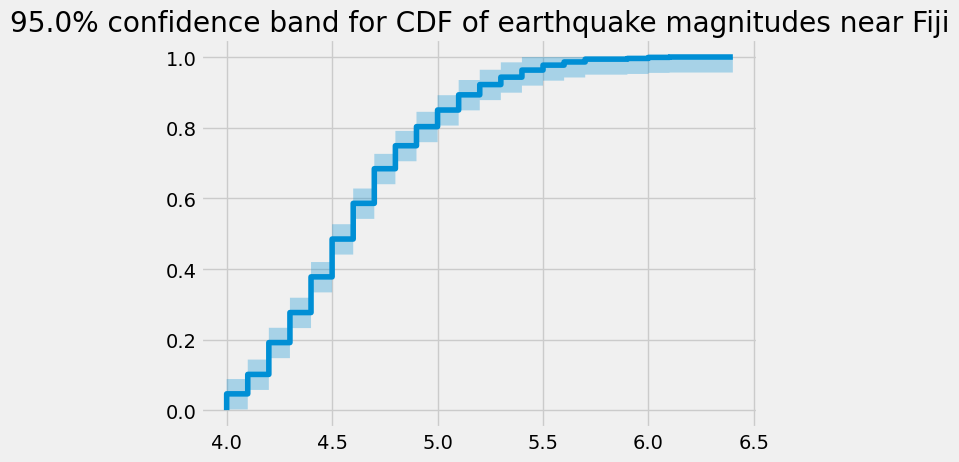

In [51]:
a = 4.3
b = 4.9
confidence = 0.95

fijiquakes = fetch_data("fijiquakes", index_col="Obs.")

x, F_hat, L, U = make_cdf_confidence_band(fijiquakes["mag"], confidence=confidence)
plt.step(x, F_hat)
plt.fill_between(x, y1=L, y2=U, alpha=0.3, step="post")
plt.title(f"{confidence * 100}% confidence band for CDF of earthquake magnitudes near Fiji")

n = fijiquakes.shape[0]
F_b = (fijiquakes["mag"] <= b).mean()
F_a = (fijiquakes["mag"] <= a).mean()
T = F_b - F_a  # P(a < Magnitude <= b)
se = np.sqrt(T * (1. - T) / n)
ci = scipy.stats.norm.interval(confidence, loc=T, scale=se)
print(f"{confidence * 100}% CI for the probability of an arbitrary earthquake near Fiji having magnitude {a} < m ≤ {b}: {ci}")

## 8.

In [50]:
confidence = 0.90

faithful = fetch_data("faithful", skiprows=25)
ci = scipy.stats.norm.interval(confidence, loc=faithful["waiting"].mean(), scale=faithful["waiting"].sem())
print(f"{confidence * 100}% CI for the mean waiting time at Old Faithful: {ci}")
median = faithful["waiting"].median()
print(f"Plug-in estimator for the median waiting time at Old Faithful: {median}")

90.0% CI for the mean waiting time at Old Faithful: (69.54117905853789, 72.25293858852092)
Plug-in estimator for the median waiting time at Old Faithful: 76.0


## 9.

This is an application of our findings in Question 2.
In particular,

$$
\hat{p}-\hat{q}\pm z_{\alpha/2}\sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}+\frac{\hat{q}\left(1-\hat{q}\right)}{n}} \approx0.05\pm0.47\times z_{\alpha/2}.
$$

The z-scores for 80% and 90% confidence intervals are approximately 1.28155 and 1.64485, respectively.

## 10.

In [49]:
confidence = 0.95

clouds = fetch_data("clouds", skiprows=29)
seeded = clouds["Seeded_Clouds"]
unseeded = clouds["Unseeded_Clouds"]
n = clouds.shape[0]
se = np.sqrt(seeded.var() / n + unseeded.var() / n)
ci = scipy.stats.norm.interval(confidence, loc=(seeded - unseeded).mean(), scale=se)
print(f"{confidence * 100}% CI for the mean difference between seeded and unseeded cloud percipitation: {ci}")

95.0% CI for the mean difference between seeded and unseeded cloud percipitation: (5.314115765120334, 549.4781919271875)


## Appendix

### Normal-based confidence interval

Suppose 

$$
\frac{\hat{\theta}-\theta}{\operatorname{se}\hat{\theta}}\approx N(0,1).
$$

Let $\epsilon>0$, $Z$ denote a standard normal random variable, and $\Phi$ be its CDF.
Then,

$$
\mathbb{P}(\hat{\theta}-\epsilon\leq\theta\leq\hat{\theta}+\epsilon)=\mathbb{P}\biggl(-\frac{\epsilon}{\operatorname{se}\hat{\theta}}\leq Z\leq\frac{\epsilon}{\operatorname{se}\hat{\theta}}\biggr)=1-2\Phi\biggl(-\frac{\epsilon}{\operatorname{se}\hat{\theta}}\biggr).
$$

It follows that $(\hat{\theta}-\epsilon,\hat{\theta}+\epsilon)$ is an approximate $1-\alpha$ confidence interval for $\theta$ if

$$
\epsilon\geq-\Phi^{-1}\biggl(\frac{\alpha}{2}\biggr)\operatorname{se}\hat{\theta}=\Phi^{-1}\biggl(1-\frac{\alpha}{2}\biggr)\operatorname{se}\hat{\theta}
$$

Some common values of $z_{\alpha/2}\equiv\Phi^{-1}(1-\alpha/2)$ are below.

In [17]:
tabulate(
    [[
        interval,
        1. - interval,
        scipy.stats.norm.ppf(1. - (1. - interval) / 2.)
    ] for interval in (0.8, 0.9, 0.95, 0.99)],
    headers=("1 - α", r"α", r"z(α/2)"),
    tablefmt="html",
)

'<table>\n<thead>\n<tr><th style="text-align: right;">  1 - α</th><th style="text-align: right;">   α</th><th style="text-align: right;">  z(α/2)</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">   0.8 </td><td style="text-align: right;">0.2 </td><td style="text-align: right;"> 1.28155</td></tr>\n<tr><td style="text-align: right;">   0.9 </td><td style="text-align: right;">0.1 </td><td style="text-align: right;"> 1.64485</td></tr>\n<tr><td style="text-align: right;">   0.95</td><td style="text-align: right;">0.05</td><td style="text-align: right;"> 1.95996</td></tr>\n<tr><td style="text-align: right;">   0.99</td><td style="text-align: right;">0.01</td><td style="text-align: right;"> 2.57583</td></tr>\n</tbody>\n</table>'